<a href="https://colab.research.google.com/github/Sahilvohra58/food-vision-101-project/blob/main/Transfer_Learning_ScalingUp_Exp_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from help_functions import create_callbacks, download_and_unzip, dir_explore, plot_loss_curve

download_and_unzip('https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip', '101_food_classes_10_percent.zip')
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"
dir_explore('101_food_classes_10_percent')

Beginning file download...
There are 2 directories and 0 files in 101_food_classes_10_percent folder.
There are 101 directories and 0 files in 101_food_classes_10_percent/train folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/carrot_cake folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/edamame folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/bread_pudding folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/lobster_roll_sandwich folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/beignets folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/tuna_tartare folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/crab_cakes folder.
There are 0 directories and 75 files in 101_food_classes_10_percent/train/frozen_yogurt folder.
There are 0 directories and 75 files in 101_food_classes

In [2]:
image_size=(224,224)
import tensorflow as tf
tf.random.set_seed = 42

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='categorical', image_size=image_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='categorical', image_size=image_size, shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = Sequential([
      preprocessing.RandomFlip(mode = 'horizontal'),
      preprocessing.RandomHeight(factor=(0.2, 0.3)),
      preprocessing.RandomRotation(factor=(-0.2, 0.3)),
      preprocessing.RandomWidth(factor=(0.2, 0.3)),
      preprocessing.RandomZoom(height_factor=(0.2, 0.3))
                                ])

In [4]:
import os
len(os.listdir(train_dir))

101

In [5]:
from tensorflow import keras
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
input = tf.keras.layers.Input(shape=image_size+(3,), name = 'input_layer')

x = data_augmentation(input)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'GlobalAveragePooling2D_Layer')(x)
output = tf.keras.layers.Dense(len(os.listdir(train_dir)), activation='softmax')(x)

model = keras.Model(input, output)

16719872/16705208 [==============================] - 0s 0us/step


In [6]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [7]:
# for layer in base_model.layers:
#   print(layer, layer.trainable)

In [13]:
import datetime
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])

log_dir = "Tensorboard/FineTuning/EfficientNet_ScalingUp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  verbose=0),
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath='Models_checkpoint_EfficientNet_ScalingUp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                     # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                     save_weights_only=True,
                     verbose=0),
                tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]



history = model.fit(train_data, 
                    epochs = 5,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15*(len(test_data))),
                    callbacks = callbacks,
                    shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
237/237 [==============================] - 81s 307ms/step - loss: 1.3407 - accuracy: 0.6499 - val_loss: 2.1340 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 2/5
237/237 [==============================] - 68s 286ms/step - loss: 1.2190 - accuracy: 0.6808 - val_loss: 2.1235 - val_accuracy: 0.4881 - lr: 1.1220e-04
Epoch 3/5
237/237 [==============================] - 68s 285ms/step - loss: 1.1400 - accuracy: 0.6990 - val_loss: 2.0547 - val_accuracy: 0.5034 - lr: 1.2589e-04
Epoch 4/5
237/237 [==============================] - 67s 281ms/step - loss: 1.0720 - accuracy: 0.7040 - val_loss: 2.1011 - val_accuracy: 0.4981 - lr: 1.4125e-04
Epoch 5/5
237/237 [==============================] - 67s 280ms/step - loss: 1.0031 - accuracy: 0.7295 - val_loss: 2.1254 - val_accuracy: 0.4942 - lr: 1.5849e-04


In [9]:
# import shutil
# shutil.rmtree('TensorBoard')

In [15]:
model.load_weights('Models_checkpoint_EfficientNet_ScalingUp/model_ep_05_val_accuracy_0.4942.ckpt')
history = model.fit(train_data, 
                    epochs = 10,
                    initial_epoch = 4,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15*(len(test_data))),
                    callbacks = callbacks,
                    shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
237/237 [==============================] - 67s 279ms/step - loss: 0.9274 - accuracy: 0.7464 - val_loss: 2.1378 - val_accuracy: 0.4931 - lr: 1.5849e-04
Epoch 6/10
237/237 [==============================] - 66s 278ms/step - loss: 0.8839 - accuracy: 0.7624 - val_loss: 2.1253 - val_accuracy: 0.5016 - lr: 1.7783e-04
Epoch 7/10
237/237 [==============================] - 66s 275ms/step - loss: 0.8337 - accuracy: 0.7702 - val_loss: 2.2085 - val_accuracy: 0.4828 - lr: 1.9953e-04
Epoch 8/10
237/237 [==============================] - 66s 277ms/step - loss: 0.7676 - accuracy: 0.7917 - val_loss: 2.2060 - val_accuracy: 0.4889 - lr: 2.2387e-04
Epoch 9/10
237/237 [==============================] - 66s 275ms/step - loss: 0.7302 - accuracy: 0.8005 - val_loss: 2.2946 - val_accuracy: 0.4785 - lr: 2.5119e-04
Epoch 10/10
237/237 [==============================] - 66s 278ms/step - loss: 0.6912 - accuracy: 0.8063 - val_loss: 2.2305 - val_accuracy: 0.4958 - lr: 2.8184e-04


In [17]:
results = model.evaluate(test_data)
results #[1.8664792776107788, 0.5666534900665283]

790/790 [==============================] - 104s 132ms/step - loss: 1.8665 - accuracy: 0.5667


[1.8664792776107788, 0.5666534900665283]

In [18]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 99s 123ms/step


In [20]:
pred = pred_probs.argmax(axis=1)
pred

array([  0,   0,   0, ...,  56,  94, 100])

In [23]:
test_labels = []
for image, label in test_data.unbatch():
  test_labels.append(label)


In [30]:
def load_and_prep(path, img_shape=224, scale=True):
  img = tf.io.read_file(path)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, size =[img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img



spaghetti_carbonara
2794464.jpg
101_food_classes_10_percent/train//spaghetti_carbonara/2794464.jpg


(64, 23)

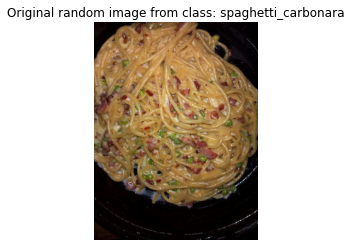

In [46]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


random_folder = random.choice(os.listdir(train_dir))
print(random_folder)
random_file = random.choice(os.listdir(train_dir+'/'+random_folder))
print(random_file)
random_image_path = train_dir + '/' + random_folder + '/' + random_file
print(random_image_path)

img_1 = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img_1) # plot the target image
plt.title(f"Original random image from class: {random_folder}")
plt.axis(False);

img_2 = load_and_prep(random_image_path)

prediction = model.predict(tf.expand_dims(img_2, axis=0)).argmax()
prediction, os.listdir(train_dir).index(random_folder)

In [49]:
from google.colab import files
import os

dir_to_zip = 'Models_checkpoint_EfficientNet_ScalingUp' #@param {type: "string"}
output_filename = 'Models_checkpoint_EfficientNet_ScalingUp.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
from google.colab import files
import os

dir_to_zip = '/content/Tensorboard' #@param {type: "string"}
output_filename = 'Tensorboard.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>